In [ ]:
%conda install -c conda-forge ipympl ipywidgets
%conda install numpy scipy matplotlib

In [2]:
%matplotlib widget

import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from Kinematics import Kinematic

np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.3f}".format(x)})

In [3]:
def build_axes():
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim([-350, 350])
    ax.set_ylim([-350, 350])
    ax.set_zlim([-350, 350])

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')

    ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

    ax.view_init(elev=5, azim=-80)

    return fig, ax

In [4]:
def draw_arms(fig, ax, km, theta, lines, end_point):
    data = km.path(theta)

    for i in range(len(data) - 1):
        lines[i].set_data(data[i:i+2, 0], data[i:i+2, 1])
        lines[i].set_3d_properties(data[i:i+2, 2])

    ep = data[-1, 0], data[-1, 1], data[-1, 2]
    end_point.set_data([ep[0]], [ep[1]])
    end_point.set_3d_properties([ep[2]])
    end_point.set_label(f"end point: ({ep[0]:.03f}, {ep[1]:.03f}, {ep[2]:.03f})\ntheta: {np.rad2deg(theta)}")
    ax.legend(handles=[end_point])
    
    fig.canvas.draw()


def forward_sim(fig, ax, km, init, lines, end_point):
    def on_theta_change(change):
        global theta
        if change['name'] != 'value': return
        
        theta = np.deg2rad([slider.value for slider in sliders])
        x = km.forward(theta)
        draw_arms(fig, ax, km, theta, lines, end_point)

    sliders = []
    for i in range(len(km.dh_params)):
        slider = widgets.FloatSlider(description=f'theta{i + 1}', min=-180, max=180, step=1, value=init[i], layout=widgets.Layout(width='50%'))
        slider.observe(on_theta_change, names='value')
        sliders.append(slider)

    display(widgets.VBox(sliders))


def inverse_sim(fig, ax, km, init, lines, end_point, dim=2):
    def on_xy_change(change):
        global theta
        if change['name'] != 'value': return

        x_des = np.array([slider.value for slider in sliders] + [0] * (3 - len(sliders)))
        _, theta = km.inverse(x_des, theta)
        draw_arms(fig, ax, km, theta, lines, end_point)

    sliders = []
    for i in range(dim):
        slider = widgets.FloatSlider(description=f'X{i + 1}', min=-345, max=345, step=0.1, value=init[i], layout=widgets.Layout(width='50%'))
        slider.observe(on_xy_change, names='value')
        sliders.append(slider)

    display(widgets.VBox(sliders))

In [5]:
dh_params = np.array([
        (12, 78, np.deg2rad(90)),
        (94, 0, 0),
        (180, 0, 0),
    ])


def in_workspace(x, dh_params):
    d1 = np.linalg.norm(x - np.array([0, 0, dh_params[0, 1]]))
    d2 = np.sum(dh_params[:, 0]) - 0.1
    return d1 < d2


km = Kinematic(dh_params=dh_params, in_workspace=in_workspace)

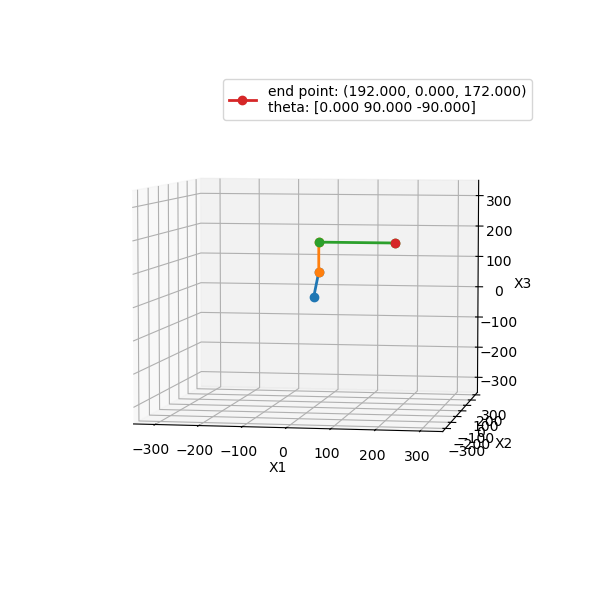

In [6]:
plt.close('all')
fig, ax = build_axes()

num_dh_params = len(km.dh_params)
lines = [ax.plot([], [], 'o-', lw=2)[0] for _ in range(num_dh_params)]
end_point = ax.plot([], [], [], 'o-', lw=2)[0]

theta = np.deg2rad([0, 90, -90])
draw_arms(fig, ax, km, theta, lines, end_point)

forward_sim(fig, ax, km, np.rad2deg(theta), lines, end_point)

[185.000 -0.000 178.000] [-0.000 94.204 -92.213]


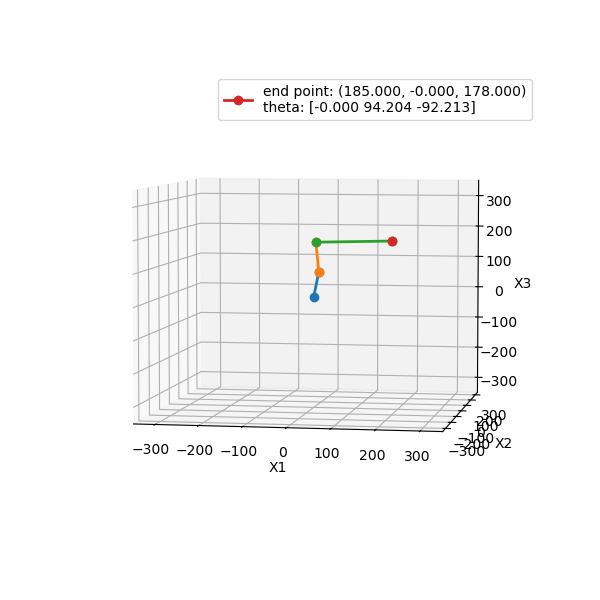

In [13]:
plt.close('all')
fig, ax = build_axes()

num_dh_params = len(km.dh_params)
lines = [ax.plot([], [], [], 'o-', lw=2)[0] for _ in range(num_dh_params)]
end_point = ax.plot([], [], [], 'o-', lw=2)[0]

theta = np.deg2rad([0, 10, -20])
x_des = np.array([185, 0, 178])
x, theta = km.inverse(x_des, theta)
print(x, np.rad2deg(theta))
draw_arms(fig, ax, km, theta, lines, end_point)

inverse_sim(fig, ax, km, x, lines, end_point, dim=3)

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rc

rc('animation', html='jshtml')  

def draw_frame(ax, km, theta, lines, end_point):
    data = km.path(theta)

    for i in range(len(data) - 1):
        lines[i].set_data(data[i:i+2, 0], data[i:i+2, 1])
        lines[i].set_3d_properties(data[i:i+2, 2])

    ep = data[-1, 0], data[-1, 1], data[-1, 2]
    end_point.set_data([ep[0]], [ep[1]])
    end_point.set_3d_properties([ep[2]])
    end_point.set_label(f"end point: ({ep[0]:.03f}, {ep[1]:.03f}, {ep[2]:.03f})\ntheta: {np.rad2deg(theta)}")
    ax.legend(handles=[end_point])

In [16]:
# path planning

def cartesian_path(x_src, x_des, n_points=2):
    if x_src.shape != x_des.shape:
        return

    path = [x_src]
    d = (x_des - x_src) / n_points
    for i in range(n_points):
        nx = path[i] + d
        path.append(nx)

    return np.stack(path)
    

x1 = np.array([170, 0, -80])
x2 = np.array([170, 0, 220])
x3 = np.array([230, 0, 220])

# # path 01
# p1 = cartesian_path(x1, x2, n_points=50)
# p2 = cartesian_path(x2, x3, n_points=50)
# path = np.vstack([p1, p2])

# path 02
path = cartesian_path(x1, x3, n_points=100)

fig, ax = build_axes()

n_dh_params = len(km.dh_params)
lines = [ax.plot([], [], 'o-', lw=2)[0] for _ in range(n_dh_params)]
end_point = ax.plot([], [], 'o-', lw=2)[0]

theta = np.deg2rad([10, -10, -10])

def update(i):
    global theta
    _, theta = km.inverse(path[i], theta)
    draw_frame(ax, km, theta, lines, end_point)

ani = FuncAnimation(fig, update, frames=len(path), interval=50)

plt.close("all")
HTML(ani.to_jshtml())


In [17]:
ani.save('sim.gif', writer='imagemagick', fps=30)